In [21]:
import pandas as pd
import numpy as np
import math
from pulp import *
from tabulate import tabulate

def optimizer (x_ij, c_ij, d_i, n_0i, R, NUM_AREA):
    prob = LpProblem("Model", LpMaximize)

    m_ij = [[0]*NUM_AREA for _ in range(NUM_AREA)]
    y_ij = [[0]*NUM_AREA for _ in range(NUM_AREA)]
    n_1i = []
    for i in range(NUM_AREA):
        n_1i.append(LpVariable("n_1%d"%(i), 0, None, LpInteger))
        for j in range(NUM_AREA):
            y_ij[i][j] = LpVariable("y_%d%d"%(i,j), 0, None, LpInteger)
            if i!=j:
                m_ij[i][j] = LpVariable("m_%d%d"%(i,j), 0, None, LpInteger)

    # ========= CONSTRUCT LP ============ #

    # Objective
    prob += sum([R*y_ij[i][j]*x_ij[i][j] - m_ij[i][j]*c_ij[i][j] for i in range(NUM_AREA) for j in range(NUM_AREA)])

    # Subject To
    for j in range(NUM_AREA):
        # n_1i
        prob += n_1i[j] == n_0i[j] + sum(m_ij[i][j] for i in range(NUM_AREA)) - sum(m_ij[j][i] for i in range(NUM_AREA)), "Equation Area: %d"%j
        # n_0i
        prob += n_0i[j] >= sum(m_ij[j][i] for i in range(NUM_AREA)), "Moving Constrain: %d"%j
        # y_ij
        prob += sum(y_ij[j][i] for i in range(NUM_AREA)) <= d_i[j] ,"Total Demand: %d"%j
        prob += sum(y_ij[i][j]*x_ij[i][j] for i in range(NUM_AREA)) <= n_1i[j] ,"Total Available: %d"%j


    # ============== SOLVE ============= #
    prob.solve()
    #return prob
    return value(prob.objective)

In [22]:
NUM_AREA = 3
R = 13.54 # Revenue

# ========== DATA ============= #

x_ij = [[0.99, 0.68, 0.17], 
        [0.68, 0.962, 0.43], 
        [0.17,0.44,0.99]] # [[row]] - x00, x01, x10, x11, move cars from j to i

c_ij = [[0, 4.14,8.1], 
        [4.14, 0, 5.2], 
        [8.1,5.2,0]] # c00, c01, c10, c11 # Move cars from i to j

c_control = [[0, 999, 6999], 
        [999, 0, 999], 
        [999,999,0]] # c00, c01, c10, c11 # Move cars from i to j

n_0i = [5,44,9999]

res = []
outs = []
controls = []
for d1 in range(80,200):
    d_i = [d1, 20,0]
    out = optimizer (x_ij, c_ij, d_i, n_0i, R, NUM_AREA)
    control = optimizer (x_ij, c_control, d_i, n_0i, R, NUM_AREA)
    res.append((out-control)/control)
    outs.append(out)
    controls.append(control)

In [18]:
prob = optimizer(x_ij, c_control,[100, 20,0], n_0i, 13.54, 3 )

In [19]:
for v in prob.variables():
    print (v.name, "=", v.varValue)
print("Objective: " ,value(prob.objective))

print("\n ======== Model Details ========= \n")
results = []
for name, c in list(prob.constraints.items()):
    results.append([name,c,  c.pi,  c.slack])
print (tabulate(results, headers=['Constrain', 'Formula', "pi", "slack"]))

m_01 = 0.0
m_02 = 0.0
m_10 = 0.0
m_12 = 0.0
m_20 = 0.0
m_21 = 0.0
n_10 = 5.0
n_11 = 44.0
n_12 = 9999.0
y_00 = 5.0
y_01 = 63.0
y_02 = 32.0
y_10 = 0.0
y_11 = 1.0
y_12 = 19.0
y_20 = 0.0
y_21 = 0.0
y_22 = 0.0
Objective:  844.38148

 ======== Model Details ========= 

Constrain            Formula                                               pi     slack
-------------------  --------------------------------------------------  ----  --------
Equation_Area:_0     m_01 + m_02 - m_10 - m_20 + n_10 = 5                  -0    -0
Moving_Constrain:_0  m_01 + m_02 <= 5                                      -0     5
Total_Demand:_0      y_00 + y_01 + y_02 <= 100                             -0    -0
Total_Available:_0   -n_10 + 0.99*y_00 + 0.68*y_10 + 0.17*y_20 <= -0.0     -0     0.05
Equation_Area:_1     -m_01 + m_10 + m_12 - m_21 + n_11 = 44                -0    -0
Moving_Constrain:_1  m_10 + m_12 <= 44                                     -0    44
Total_Demand:_1      y_10 + y_11 + y_12 <= 20        

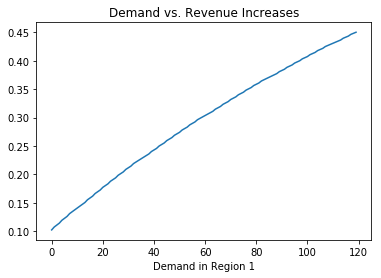

In [23]:
import matplotlib.pyplot as plt
plt.plot(res)
plt.xlabel("Demand in Region 1")
plt.title("Demand vs. Revenue Increases")
plt.show()